# Classification Analysis on Car Seats Data

We will divide the house prices in two categories and then try to predict those. The categories represents the target that the Car Seat Company is trying to reach and if that has been reached.

Author: Julia Hammerer, Vanessa Mai 
Last Changes: 10.12.2018

In [142]:
import sys
sys.path.insert(0, '../helper/')

In [143]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
import itertools
from scipy import interp
from sklearn import svm
from xgboost import XGBClassifier, plot_importance
from helper import plot_confusion_matrix
from sklearn.dummy import DummyClassifier

In [144]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")


## Data Prep

In [145]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [146]:
df=pd.read_csv("../data/Carseats.csv")
df.head()

,Unnamed: 0,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,1,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,2,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,3,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,4,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,5,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [147]:
df = df.drop(columns=["Unnamed: 0"])

In [148]:
def Sales_target(row):
    if row["Sales"]<=7.49:
        return "No"
    else:
        return "Yes"


df["AboveTarget"]= df.apply(lambda row: Sales_target(row), axis=1)

In [149]:
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,AboveTarget
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,No
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No,No


In [150]:
df.drop(columns=["Sales"], inplace=True)

In [151]:
# we have to encode our categorical data
cols_to_transform= df.drop(columns=["AboveTarget"]).select_dtypes(include='object').columns.values
df_hot1encoded= pd.get_dummies(df, columns=cols_to_transform, prefix=cols_to_transform, drop_first=True)

In [152]:
df_hot1encoded.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,AboveTarget,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
0,138,73,11,276,120,42,17,Yes,0,0,1,1
1,111,48,16,260,83,65,10,Yes,1,0,1,1
2,113,35,10,269,80,59,12,Yes,0,1,1,1
3,117,100,4,466,97,55,14,No,0,1,1,1
4,141,64,3,340,128,38,13,No,0,0,1,0


In [153]:
display(df_hot1encoded.head())
print(df_hot1encoded.shape)

,CompPrice,Income,Advertising,Population,Price,Age,Education,AboveTarget,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
0,138,73,11,276,120,42,17,Yes,0,0,1,1
1,111,48,16,260,83,65,10,Yes,1,0,1,1
2,113,35,10,269,80,59,12,Yes,0,1,1,1
3,117,100,4,466,97,55,14,No,0,1,1,1
4,141,64,3,340,128,38,13,No,0,0,1,0


(400, 12)


In [154]:
featureCols=df_hot1encoded.columns.tolist()
featureCols.remove("AboveTarget")

targetCol=df_hot1encoded["AboveTarget"]

In [155]:
X= df_hot1encoded[featureCols].values
y= df_hot1encoded["AboveTarget"].values

In [156]:
scaler= StandardScaler()
scaler.fit_transform(X)

array([[ 0.85,  0.16,  0.66, ..., -1.1 ,  0.65,  0.74],
       [-0.91, -0.74,  1.41, ..., -1.1 ,  0.65,  0.74],
       [-0.78, -1.2 ,  0.51, ...,  0.91,  0.65,  0.74],
       ...,
       [ 2.42, -1.53,  0.81, ...,  0.91,  0.65,  0.74],
       [-1.63,  0.37,  0.05, ..., -1.1 ,  0.65,  0.74],
       [ 0.59, -1.13, -1.  , ..., -1.1 ,  0.65,  0.74]])

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


## Model Comparison
in order to compare the models, we will save the models and the CV-results in a list:


In [158]:
opt_models = []

## Baseline 

In [159]:
baseline_clf = DummyClassifier(strategy='most_frequent', random_state=0)
baseline_clf.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=0, strategy='most_frequent')

In [160]:
# add the baseline model
opt_models.append(("Baseline",baseline_clf))

## Logistic Regression Iteration 1

In [161]:
pipe1 = Pipeline([('stdSc', StandardScaler()),
                 ('clf', LogisticRegression(C=0.1,random_state=1)) 
                ])

In [162]:
pipe1.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('stdSc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [163]:
y_pred=pipe1.predict(X_test)


In [164]:
print('Training Accuracy: %.3f' % pipe1.score(X_train, y_train)) 
print('Test Accuracy: %.3f' % pipe1.score(X_test, y_test)) 

Training Accuracy: 0.893
Test Accuracy: 0.842


Confusion matrix, without normalization
[[48  3]
 [16 53]]


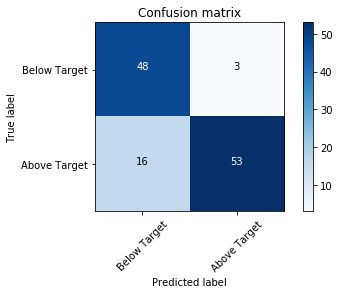

In [165]:
class_names = ('Below Target', 'Above Target')

confusion_mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion_mat, normalize=False, classes=class_names)

In [166]:
print ("Accuracy:       ",accuracy_score(y_test, y_pred))
print ("Precision:      ",precision_score(y_test, y_pred,average=None))
print ("Recall:         ",recall_score(y_test, y_pred,average=None))
print ("F1-Score:       ",f1_score(y_test, y_pred,average=None))

Accuracy:        0.8416666666666667
Precision:       [0.75 0.95]
Recall:          [0.94 0.77]
F1-Score:        [0.83 0.85]


Results for the `Middle Class`is better than the others. This is expected, since there are more samples for that class. Overall, the results are somewhat good. Let's try optimizing it all a bit. 

## Logistic Regression Iteration 2
Gridsearch plus CV

In [167]:
pipe1.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('stdSc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])>

In [168]:
# since newton-cg and saga only accepts l2 penalty, we will only use that in the gridsearch
penalties=["l2"]
c=np.logspace(-4, 0, 40)
solvers = ["newton-cg", "sag", "saga", "lbfgs"]

param_grid_lr={'clf__penalty' : penalties,
            'clf__C' :c,
              'clf__solver': solvers}

In [169]:
lr_randSearch = RandomizedSearchCV(estimator=pipe1, param_distributions=param_grid_lr,scoring='accuracy',cv=10, n_iter=8)
lr_randSearch.fit(X_train, y_train)


RandomizedSearchCV(cv=10, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('stdSc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=8, n_jobs=1,
          param_distributions={'clf__penalty': ['l2'], 'clf__C': array([1.00000e-04, 1.26638e-04, 1.60372e-04, 2.03092e-04, 2.57191e-04,
       3.25702e-04, 4.12463e-04, 5.22335e-04, 6.61474e-04, 8.37678e-04,
       1.06082e-03, 1.34340e-03, 1.70125e-03, 2.15443e-03, 2.72833e-03,
       3.45511e-03, 4.37548e-...e-01, 6.23551e-01, 7.89652e-01, 1.00000e+00]), 'clf__solver': ['newton-cg', 'sag', 'saga', 'lbfgs']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_t

In [170]:
print("Best Configuration found by Grid Search")
print(lr_randSearch.best_score_)
print(lr_randSearch.best_params_)
print(lr_randSearch.best_estimator_)

Best Configuration found by Grid Search
0.8714285714285714
{'clf__solver': 'saga', 'clf__penalty': 'l2', 'clf__C': 0.11937766417144358}
Pipeline(memory=None,
     steps=[('stdSc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.11937766417144358, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=1,
          solver='saga', tol=0.0001, verbose=0, warm_start=False))])


In [171]:
pipe2=lr_randSearch.best_estimator_
pipe2.fit(X_train, y_train)
y_pred=pipe2.predict(X_test)
confusion_mat=confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall: ",recall_score(y_test, y_pred,average=None))
print("Precision: ",precision_score(y_test, y_pred,average=None))
print("F1: ",f1_score(y_test, y_pred,average=None))
print(confusion_mat)


Accuracy:  0.8583333333333333
Recall:  [0.96 0.78]
Precision:  [0.77 0.96]
F1:  [0.85 0.86]
[[49  2]
 [15 54]]


In [172]:
# add model to summary
opt_models.append(("Log Reg", pipe2.steps[1][1]))


Recall is not as good as the other scores. 

In [173]:
score=cross_val_score(pipe2, X, y, scoring="accuracy", cv=10)

In [174]:
score.mean()
print("Mean accuracy: %5.2f (+/-%5.2f) "%(score.mean(), score.std()))

Mean accuracy:  0.87 (+/- 0.07) 


Confusion matrix, without normalization
[[49  2]
 [15 54]]


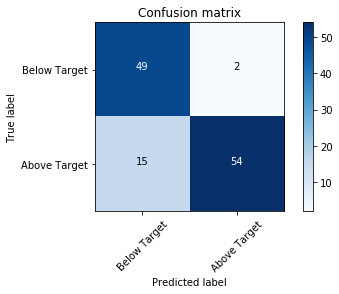

In [175]:

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

Same results as before.

### Feature Importance (LR)


In [176]:
LRImp=pd.DataFrame(index=featureCols, columns=["LR"])
LRImp["LR"]=pipe2.steps[1][1].coef_[0]
feature_imp=LRImp.sort_values(by="LR", ascending=False)

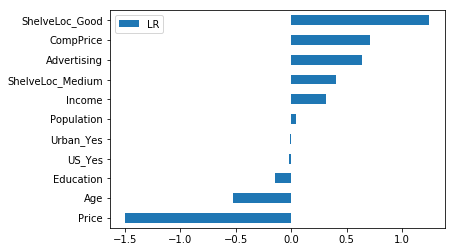

In [177]:
feature_imp.sort_values(by="LR", ascending=True).plot(kind="barh")

## Logistic Regression Iteration 3
- used subset of feature based on previous Logistic Regression

In [178]:
sel_features=feature_imp[abs(feature_imp["LR"])>0.05].index.tolist()

In [179]:
pipe3 = Pipeline([('stdSc', StandardScaler()),
                 ('clf', LogisticRegression(C=0.1,random_state=1)) 
                ])

In [180]:
# since newton-cg and saga only accepts l2 penalty, we will only use that in the gridsearch
penalties=["l2"]
c=np.logspace(-4, 0, 40)
solvers = ["newton-cg", "sag", "saga", "lbfgs"]

param_grid_lr={'clf__penalty' : penalties,
            'clf__C' :c,
              'clf__solver': solvers}

In [181]:
lr_randSearch2 = RandomizedSearchCV(estimator=pipe3, param_distributions=param_grid_lr,scoring='accuracy',cv=10, n_iter=8)
lr_randSearch2.fit(X_train, y_train)


RandomizedSearchCV(cv=10, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('stdSc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=8, n_jobs=1,
          param_distributions={'clf__penalty': ['l2'], 'clf__C': array([1.00000e-04, 1.26638e-04, 1.60372e-04, 2.03092e-04, 2.57191e-04,
       3.25702e-04, 4.12463e-04, 5.22335e-04, 6.61474e-04, 8.37678e-04,
       1.06082e-03, 1.34340e-03, 1.70125e-03, 2.15443e-03, 2.72833e-03,
       3.45511e-03, 4.37548e-...e-01, 6.23551e-01, 7.89652e-01, 1.00000e+00]), 'clf__solver': ['newton-cg', 'sag', 'saga', 'lbfgs']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_t

In [182]:
print("Best Configuration found by Grid Search")
print(lr_randSearch2.best_score_)
print(lr_randSearch2.best_params_)
print(lr_randSearch2.best_estimator_)

Best Configuration found by Grid Search
0.8857142857142857
{'clf__solver': 'newton-cg', 'clf__penalty': 'l2', 'clf__C': 0.49238826317067363}
Pipeline(memory=None,
     steps=[('stdSc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.49238826317067363, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=1,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False))])


In [183]:
pipe3=lr_randSearch.best_estimator_
pipe3.fit(X_train, y_train)
y_pred=pipe3.predict(X_test)
confusion_mat=confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall: ",recall_score(y_test, y_pred,average=None))
print("Precision: ",precision_score(y_test, y_pred,average=None))
print("F1: ",f1_score(y_test, y_pred,average=None))


Accuracy:  0.8583333333333333
Recall:  [0.96 0.78]
Precision:  [0.77 0.96]
F1:  [0.85 0.86]


Confusion matrix, without normalization
[[49  2]
 [15 54]]


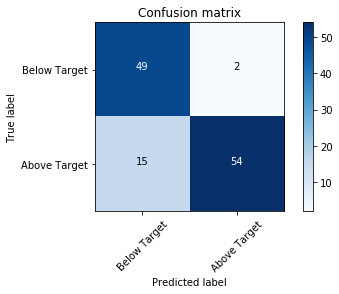

In [184]:

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

Model did not improve much. Model can differentiate between low and high very well. For distinguishing between middle and low or middle and upper it has a little more difficulty.

## SVM

In [185]:
pipe_svm1 = Pipeline([('stdSc', StandardScaler()),
                 ('clf', svm.SVC() )
                ])

In [186]:
pipe_svm1.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('stdSc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [187]:
y_pred=pipe_svm1.predict(X_test)


In [188]:
print('Training Accuracy: %.3f' % pipe_svm1.score(X_train, y_train)) 
print('Test Accuracy: %.3f' % pipe_svm1.score(X_test, y_test)) 

Training Accuracy: 0.946
Test Accuracy: 0.825


Confusion matrix, without normalization
[[46  5]
 [16 53]]


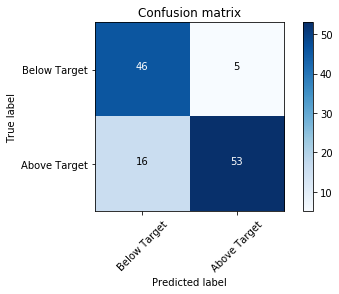

In [189]:
cnf_mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_mat,class_names)

In [190]:
print ("Accuracy:       ",accuracy_score(y_test, y_pred))
print ("Precision:      ",precision_score(y_test, y_pred,average=None))
print ("Recall:         ",recall_score(y_test, y_pred,average=None))
print ("F1-Score:       ",f1_score(y_test, y_pred,average=None))

Accuracy:        0.825
Precision:       [0.74 0.91]
Recall:          [0.9  0.77]
F1-Score:        [0.81 0.83]


## SVM iteration 2
Let's try optimizing this model


In [191]:
pipe_svm1.get_params().keys()

dict_keys(['memory', 'steps', 'stdSc', 'clf', 'stdSc__copy', 'stdSc__with_mean', 'stdSc__with_std', 'clf__C', 'clf__cache_size', 'clf__class_weight', 'clf__coef0', 'clf__decision_function_shape', 'clf__degree', 'clf__gamma', 'clf__kernel', 'clf__max_iter', 'clf__probability', 'clf__random_state', 'clf__shrinking', 'clf__tol', 'clf__verbose'])

In [192]:
param_grid_svm = [
 {'clf__C': [1, 10, 100, 1000], 'clf__kernel': ['linear']},
 {'clf__C': [1, 10, 100, 1000], 'clf__gamma': [0.001, 0.0001], 'clf__kernel': ['rbf']},
]

In [193]:
svm_GridSearch = GridSearchCV(estimator=pipe_svm1, param_grid=param_grid_svm,scoring='accuracy',cv=10)
svm_GridSearch.fit(X_train, y_train)


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('stdSc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'clf__C': [1, 10, 100, 1000], 'clf__kernel': ['linear']}, {'clf__C': [1, 10, 100, 1000], 'clf__gamma': [0.001, 0.0001], 'clf__kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [194]:
print("Best Configuration found by Grid Search")
print(svm_GridSearch.best_score_)
print(svm_GridSearch.best_params_)
print(svm_GridSearch.best_estimator_)

Best Configuration found by Grid Search
0.8928571428571429
{'clf__C': 100, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
Pipeline(memory=None,
     steps=[('stdSc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


In [195]:
pipe_svm2=svm_GridSearch.best_estimator_
pipe_svm2.fit(X_train, y_train)
y_pred=pipe_svm2.predict(X_test)
confusion_mat=confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall: ",recall_score(y_test, y_pred,average=None))
print("Precision: ",precision_score(y_test, y_pred,average=None))
print("F1: ",f1_score(y_test, y_pred,average=None))


Accuracy:  0.8583333333333333
Recall:  [0.94 0.8 ]
Precision:  [0.77 0.95]
F1:  [0.85 0.87]


Confusion matrix, without normalization
[[48  3]
 [14 55]]


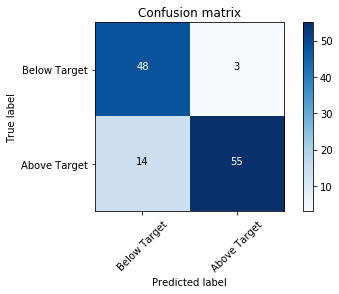

In [196]:

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

In [197]:
# add model to summary
opt_models.append(("SVM", pipe_svm2.steps[1][1]))


### XGBoost

In [198]:
X_train = pd.DataFrame(data=X_train, columns=featureCols)
X_test = pd.DataFrame(data=X_test, columns=featureCols)

In [199]:
xgb= XGBClassifier(max_depth=4, learning_rate=0.05, n_estimators=200,
                   objective='binary:logistic', gamma=0., 
                   max_delta_step=0., subsample=0.9, colsample_bytree=0.9,
                   seed=0)  
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.0, learning_rate=0.05,
       max_delta_step=0.0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9)

In [200]:
y_pred = xgb.predict(X_test)

Confusion matrix, without normalization
[[44  7]
 [19 50]]


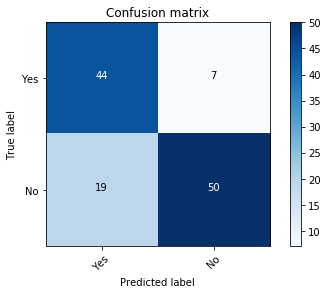

In [201]:
class_names = ("Yes","No")

confusion_mat = confusion_matrix(y_test, y_pred)
#print(confusion_mat)
plot_confusion_matrix(confusion_mat, classes=class_names, title='Confusion matrix')

In [202]:
print ("Accuracy:       ",accuracy_score(y_test, y_pred))
print ("Precision:      ",precision_score(y_test, y_pred,average=None))
print ("Recall:         ",recall_score(y_test, y_pred,average=None))
print ("F1-Score:       ",f1_score(y_test, y_pred,average=None))

Accuracy:        0.7833333333333333
Precision:       [0.7  0.88]
Recall:          [0.86 0.72]
F1-Score:        [0.77 0.79]


### Feature Importance

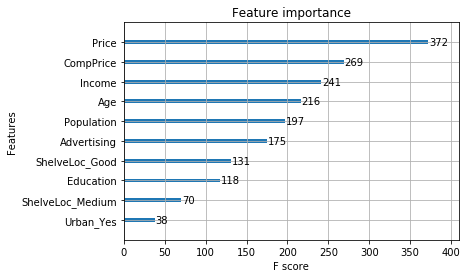

In [203]:
plot_importance(xgb,max_num_features=10)
plt.show()

### Hyperparameter tuning
We apply a gridsearch to see if we can tune our parameters for a better accuracy.

In [204]:
param_test = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6],
 'colsample_bytree':[0.1,0.4,0.6],
}

gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                         min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                         objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                         param_grid = param_test,n_jobs=4,iid=False, cv=5)

In [205]:
model2 = gsearch.fit(X_train, y_train)

In [206]:
y_pred = model2.predict(X_test)

Confusion matrix, without normalization
[[46  5]
 [19 50]]


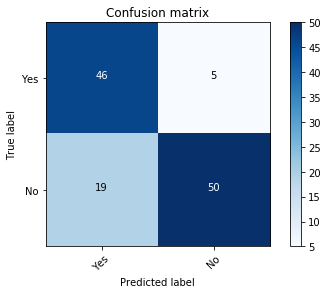

In [207]:
class_names = ('Yes','No')

confusion_mat = confusion_matrix(y_test, y_pred)
#print(confusion_mat)
plot_confusion_matrix(confusion_mat, classes=class_names, title='Confusion matrix')

In [208]:
print ("Accuracy:       ",accuracy_score(y_test, y_pred))
print ("Precision:      ",precision_score(y_test, y_pred,average=None))
print ("Recall:         ",recall_score(y_test, y_pred,average=None))
print ("F1-Score:       ",f1_score(y_test, y_pred,average=None))

Accuracy:        0.8
Precision:       [0.71 0.91]
Recall:          [0.9  0.72]
F1-Score:        [0.79 0.81]


In [209]:
# add model to summary
opt_models.append(("XGBoost", model2))

## Comparison of Models

In [210]:
opt_models

[('Baseline',
  DummyClassifier(constant=None, random_state=0, strategy='most_frequent')),
 ('Log Reg',
  LogisticRegression(C=0.11937766417144358, class_weight=None, dual=False,
            fit_intercept=True, intercept_scaling=1, max_iter=100,
            multi_class='ovr', n_jobs=1, penalty='l2', random_state=1,
            solver='saga', tol=0.0001, verbose=0, warm_start=False)),
 ('SVM', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)),
 ('XGBoost', GridSearchCV(cv=5, error_score='raise',
         estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
         max_depth=5, min_child_weight=2, missing=None, n_estimators=140,
         n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
     

Baseline: 0.452500 (0.036142)
Log Reg: 0.795000 (0.080467)
SVM: 0.605000 (0.099875)
XGBoost: 0.830000 (0.073993)


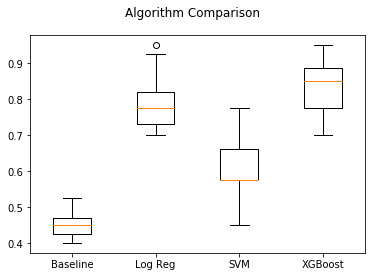

In [211]:
seed=7
# evaluate each model in turn
opt_results = []
opt_names = []
scoring = 'accuracy'
for name, model in opt_models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    opt_results.append(cv_results)
    opt_names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(opt_results)
ax.set_xticklabels(opt_names)
plt.show()

## Summary

We can see that the XGBoost Algorithm performs best on our Dataset. With an Accuracy of 83% it is a little bit better than the logistic regression.
With 60% the SVM was the not really good.
The optimized Models performed overall better.

Interesting is, that the Logistic Regression ranked other features higher in importance than the XGBoost.
Nevertheless the features were quite similar which can be interpreted as stability of our models.